# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from numpy import random
import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [6]:
# données
data = np.genfromtxt('data.csv', delimiter=',')
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [7]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [8]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

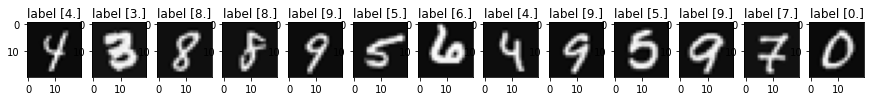

In [9]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [10]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [11]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [12]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [13]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [14]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [15]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z));

In [16]:
def computeCost(X, YY, theta1, theta2,hidden_layer_size, lambda_):
    # Froward Probagation
    # on ajoute une colonne de 1 biais pour chaque Layer
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    # Dernier Layer (Resultat)
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3)))));

    # Supprimez la première colonne de theta1 et theta2, car la régularisation commence à partir de 1
    theta1_couper = theta1[:,1:theta1.shape[1]]
    theta2_couper = theta2[:,1:theta2.shape[1]]
    
    sum1 = (lambda_ / (2 * X.shape[0])) * theta1_couper * theta1_couper
    sum2 = (lambda_ / (2 * X.shape[0])) * theta2_couper * theta2_couper

    sum = sum1.sum() + sum2.sum()
    J = J + sum

    return J 

computeCost(X, YY, W1, W2,hidden_layer_size, 1)

10.537574444826943

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [17]:
def sigmoidGradient(z):
    g = Sigmoid(z)*(1-Sigmoid(z))
    return g

def NNCostFunction(X, YY, theta1, theta2,hidden_layer_size,lambda_):
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    m = X.shape[0]

    returnOfcomputeCost = computeCost(X,YY,np.array(theta1), np.array(theta2),hidden_layer_size,lambda_)
    J  = returnOfcomputeCost
    
    a1 = X
    z2 = np.dot(a1,np.transpose(theta1))
    a2 = Sigmoid(z2)
    a2 = np.hstack((np.ones((m,1)),a2))
    z3 = np.dot(a2,np.transpose(theta2))
    a3  = Sigmoid(z3)
    
    delta3 = np.zeros((m,num_labels))
    delta2 = np.zeros((m,hidden_layer_size))
    for i in range(m):
        delta3[i,:] = a3[i,:]-YY[i,:]
        theta2_grad = theta2_grad + np.dot(np.transpose(delta3[i,:].reshape(1,-1)),a2[i,:].reshape(1,-1))

        delta2[i,:] = np.dot(delta3[i,:].reshape(1,-1),theta2[:,1:theta2.shape[1]])*sigmoidGradient(z2[i,:])
        theta1_grad = theta1_grad + np.dot(np.transpose(delta2[i,:].reshape(1,-1)),a1[i,:].reshape(1,-1))
    
    theta2_grad = (1 / m) * theta2_grad
    theta1_grad = (1 / m) * theta1_grad


    # Regularisation 
    theta1_grad[:, 1:] = theta1_grad[:, 1:] + (lambda_ / m) * theta1[:, 1:]
    theta2_grad[:, 1:] = theta2_grad[:, 1:] + (lambda_ / m) * theta2[:, 1:]
    
    # Unroll gradients
    grad = []
    grad.append(theta1_grad)
    grad.append(theta2_grad)
    
    return J, grad

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [18]:
def gradientDescent(X, YY , theta1,theta2, alpha, iterations, lambda_=0):
  t1 = theta1
  t2 = theta2
  lc = []
  for i in range(iterations):
    if(i%100==0):print(i)
    cost , g = NNCostFunction(X, YY, t1, t2,hidden_layer_size,lambda_)
    #print(cost)
    lc.append(cost)
    t1 = t1 - alpha * g[0]
    t2 = t2 - alpha * g[1]

  final_t = [t1,t2]
  return lc , final_t

In [19]:
iterations =5000
alpha = 1.7

thetaRandom = [np.random.normal(0,0.25, W1.shape), np.random.normal(0, 0.25, W2.shape)]
costs , tehtas = gradientDescent(X,YY,thetaRandom[0],thetaRandom[1],alpha,iterations)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [24]:
y_pred=predict(tehtas[0],tehtas[1],X)
print(precision(y_pred,y))

99.86


# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [25]:
iterations =5000
alpha = 1.7

thetaRandom = [np.random.normal(0,0.25, W1.shape), np.random.normal(0, 0.25, W2.shape)]
costs , theta__ = gradientDescent(X,YY,thetaRandom[0],thetaRandom[1],alpha,iterations,lambda_=1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [26]:
def predict (W1, W2, X):
    m = np.size(X, 0)
    p = np.zeros(m)
    
    h1 = Sigmoid(np.dot(X , W1.T))
    h2 = Sigmoid(np.dot(np.concatenate((np.ones((m, 1)), h1), axis=1) , W2.T))
    y_pred = ( np.argmax(h2, axis=1) )%10
    return y_pred

In [27]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
def precision(yp,y):
  cpt = 0 
  for i in range(len(y)):
    if (yp[i] == y[i]):
      cpt = cpt + 1 
  return cpt/len(yp)*100


y_pred=predict(tehtas[0],tehtas[1],X)
y_pred__=predict(theta__[0],theta__[1],X)
print("Sans Regularisation ",precision(y_pred,y))
print("Avec Regularisation",precision(y_pred__,y))

Sans Regularisation  99.86
Avec Regularisation 99.22


# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [28]:
clf = MLPClassifier( alpha=0.01, max_iter=5000,hidden_layer_sizes=(25,), random_state=42, activation='logistic',solver='sgd')
clf.fit(X[:, 1:], YY)
y_pred = np.argmax(clf.predict(X[:, 1:]), axis=1)[:, np.newaxis] #reshape to (5000,1)
precision = np.mean(y==y_pred)*100
precision

90.06

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

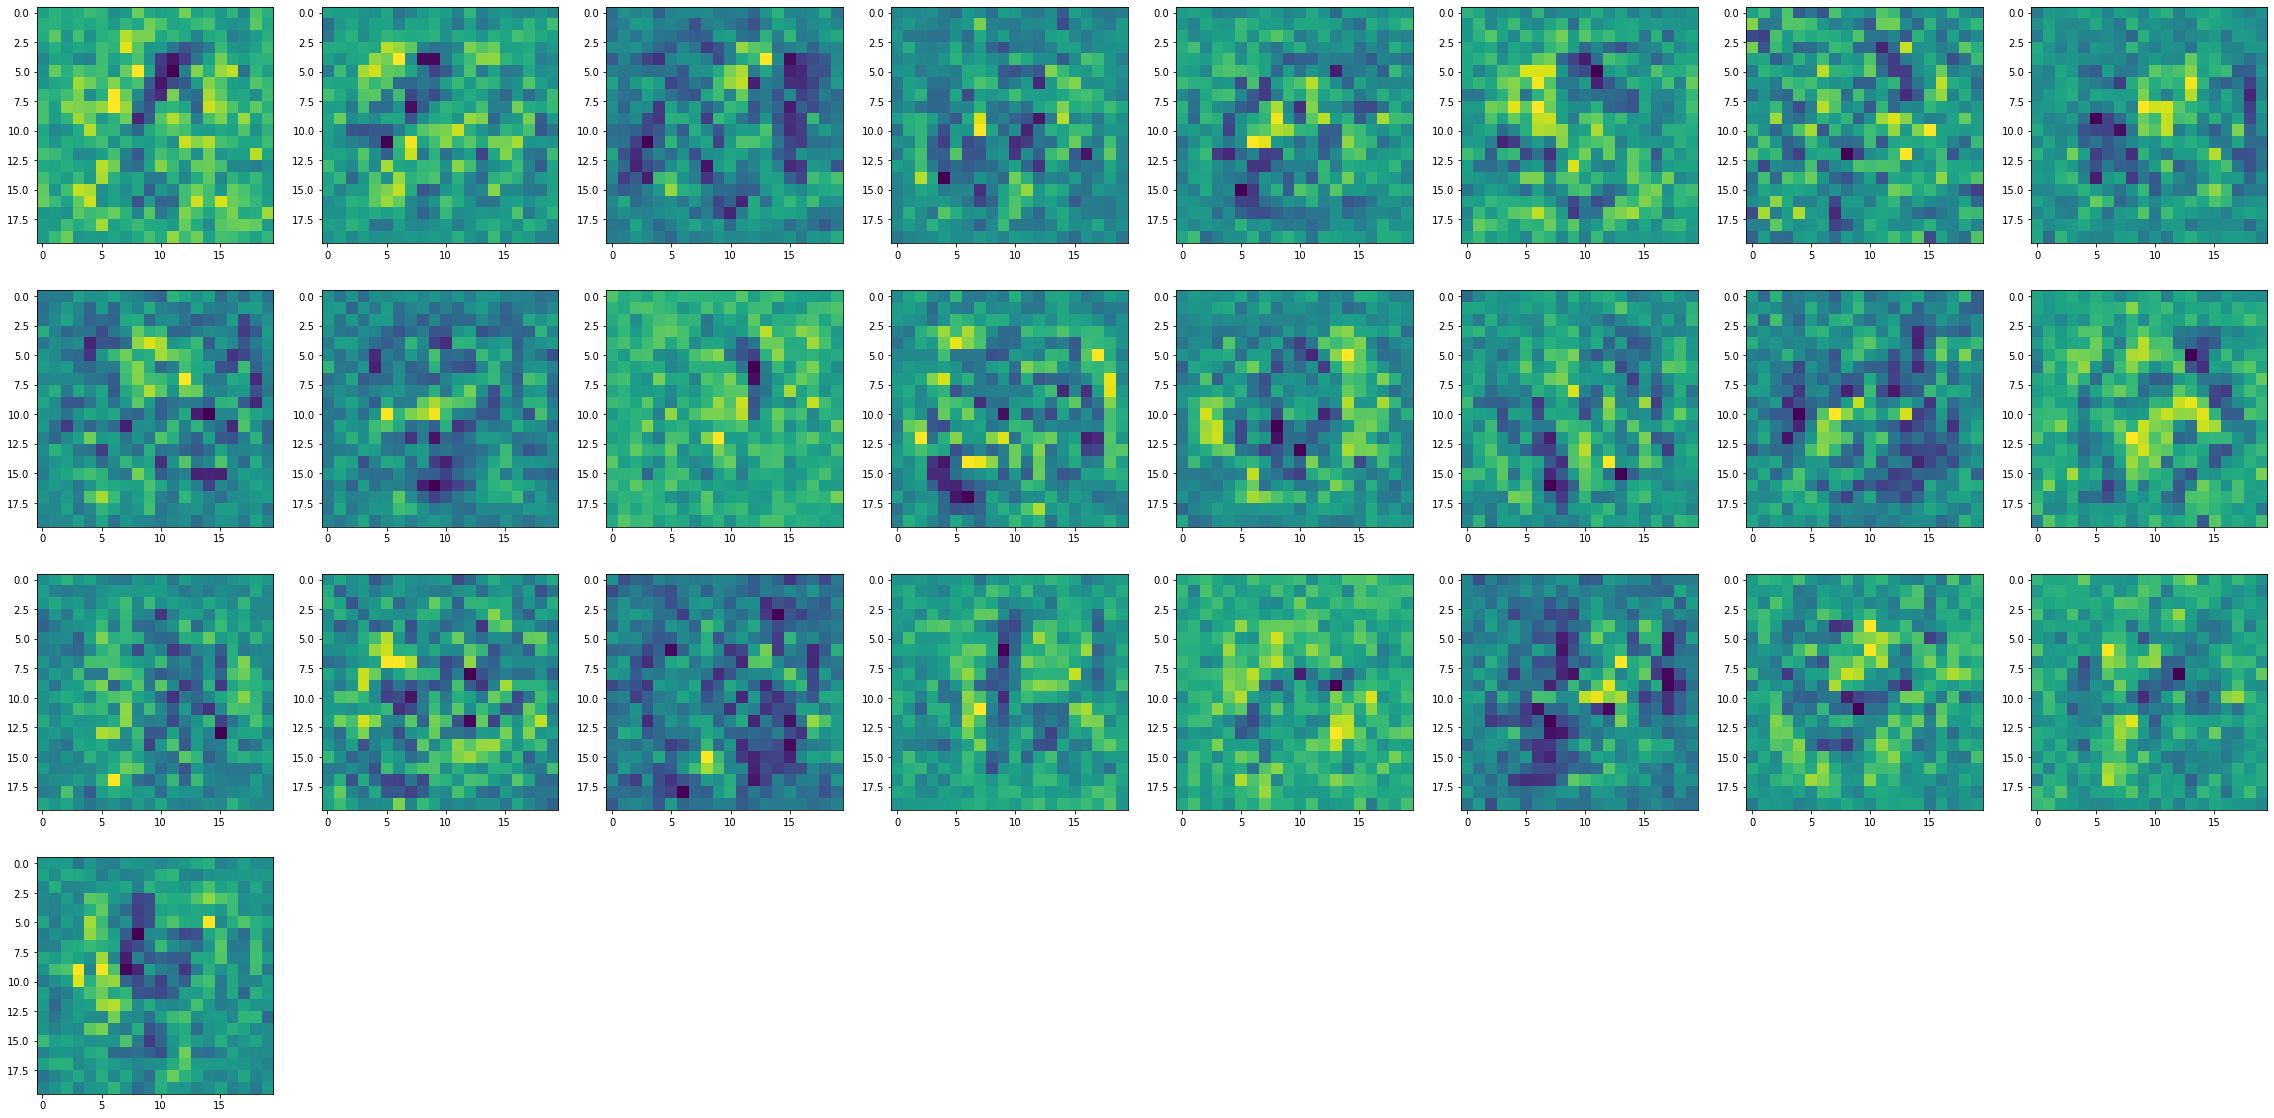

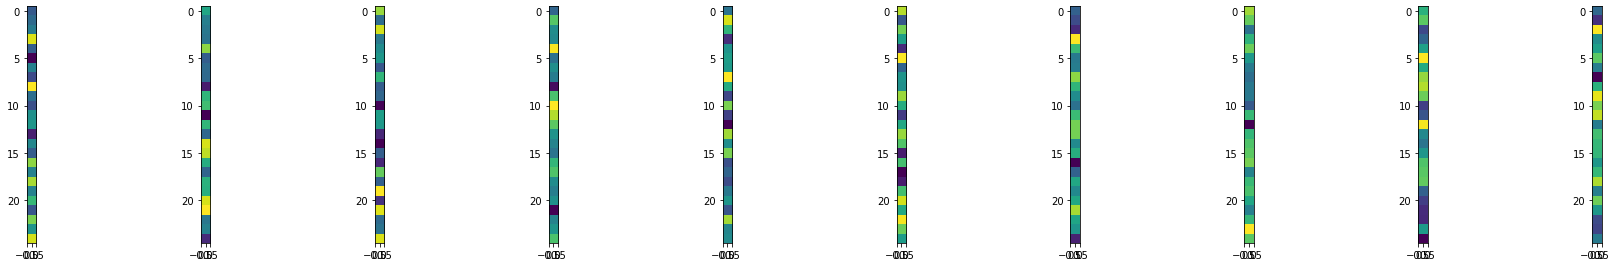

In [29]:
def visualize_weights(w1, w2):
    plt.figure(figsize=(40, 20))
    for i in range(w1.shape[0]):
        plt.subplot(4, 8, i + 1)
        plt.imshow(np.reshape(w1[i][1:], (20, 20)))
    plt.figure(figsize=(40, 20))
    for i in range(w2.shape[0]):
        plt.subplot(4, 13, w1.shape[0] + i + 2)
        plt.imshow(np.reshape(w2[i][1:], (-1, 1)))
visualize_weights(tehtas[0],tehtas[1])

**Visualisation apres Régularisation**

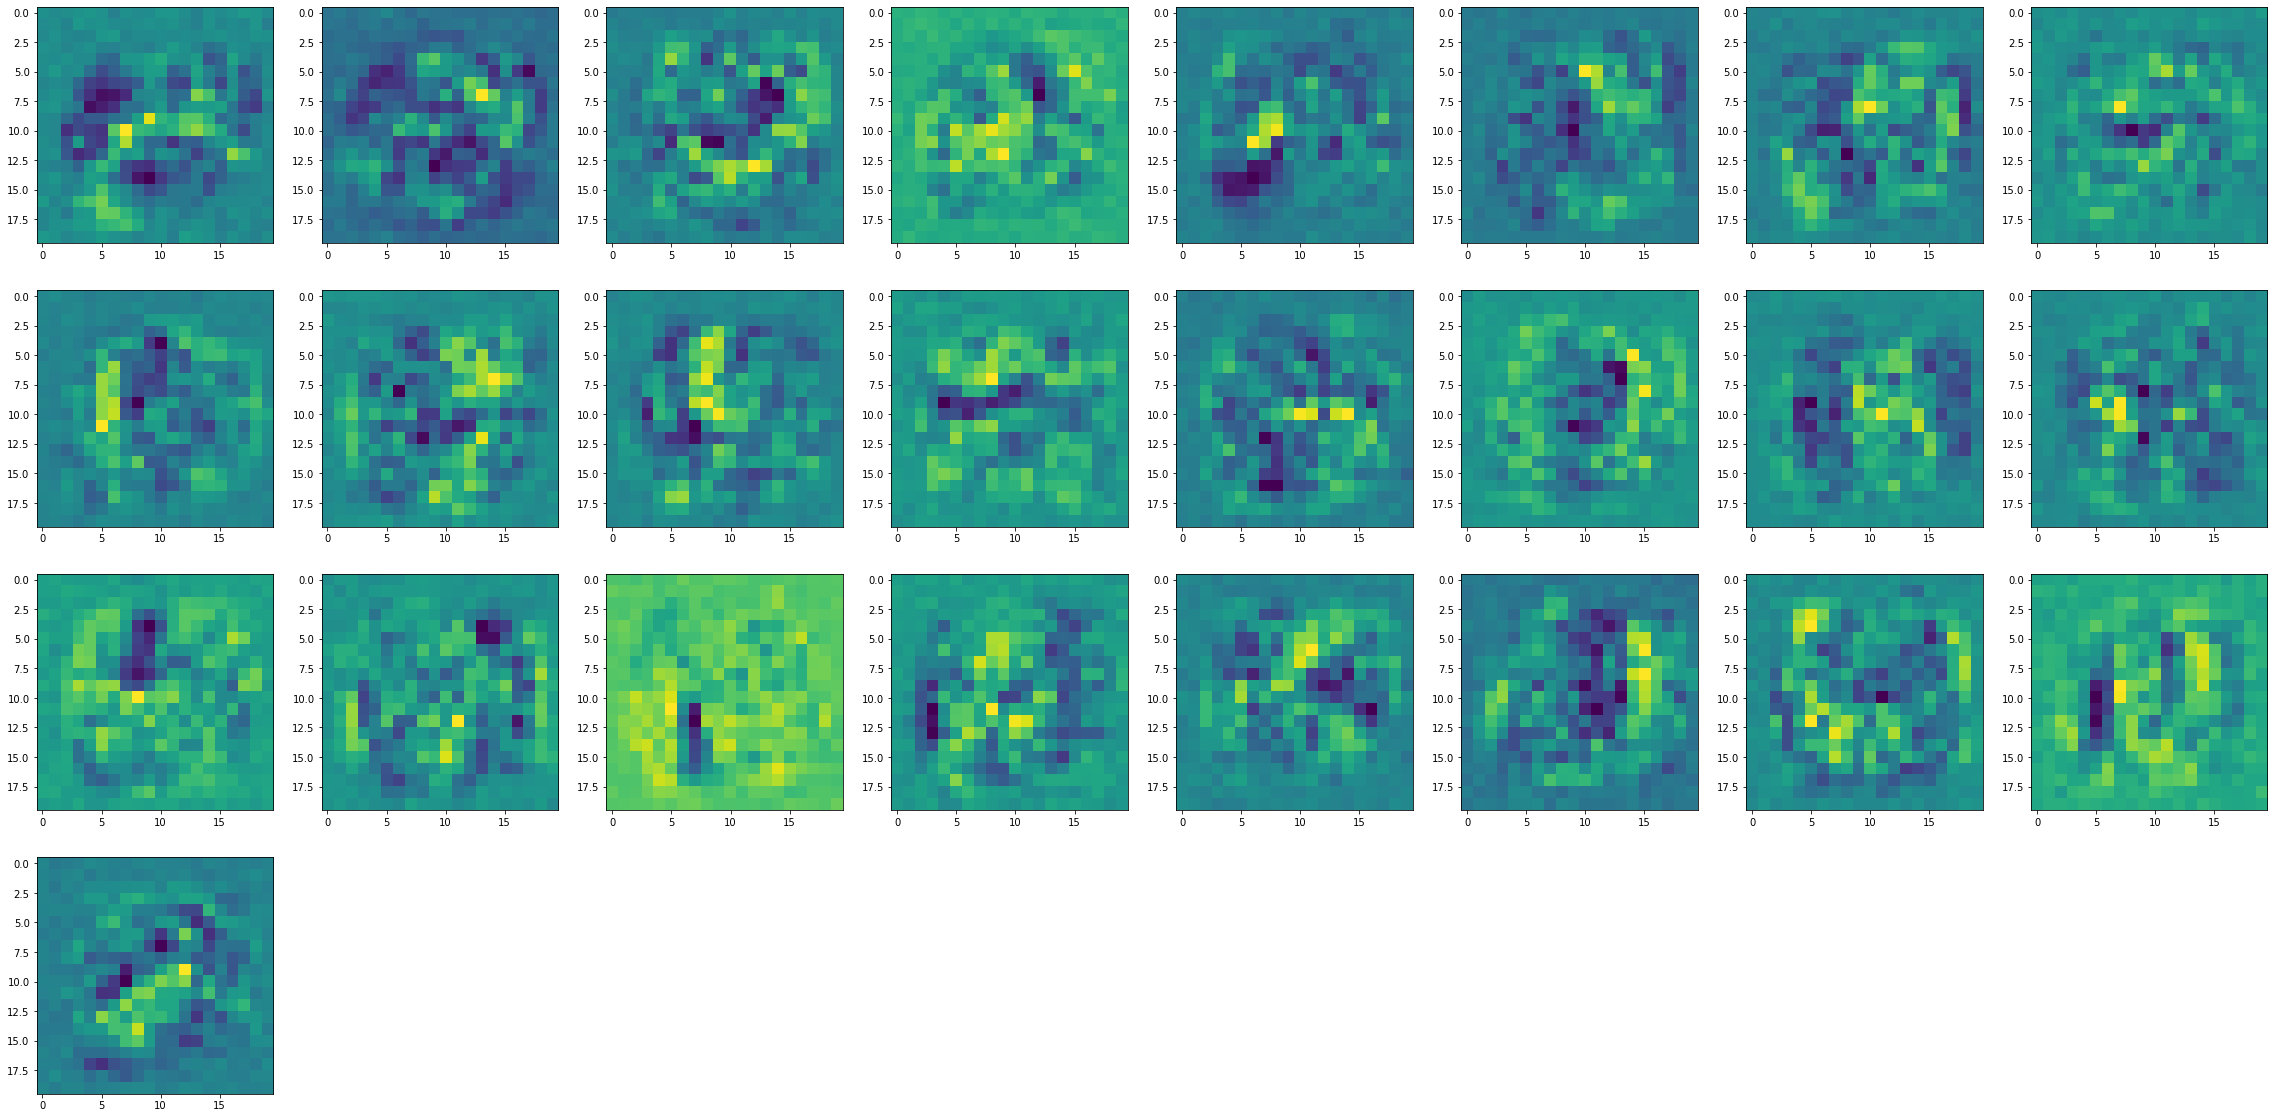

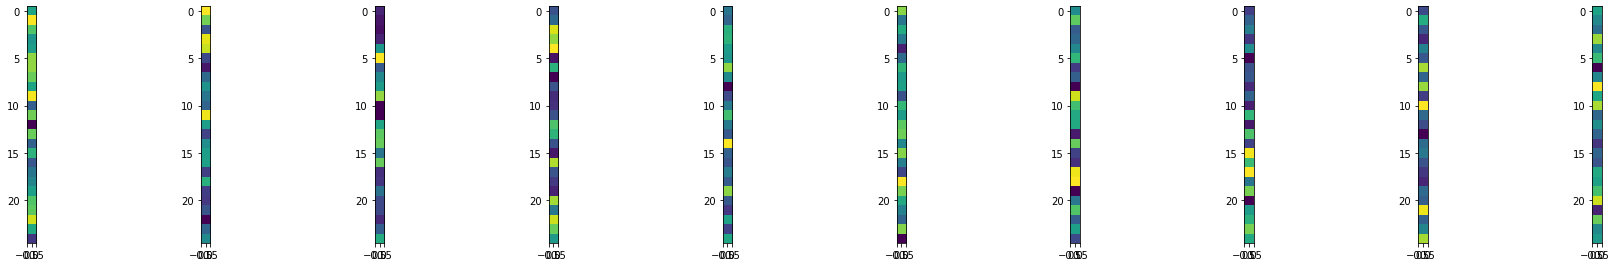

In [30]:
visualize_weights(theta__[0],theta__[1])

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage
pour cela nous l'avons ululiser optimisation de descente de gradient par momentum qui permet à la recherche de créer de l'inertie dans une direction dans l'espace de recherche et de surmonter les oscillations de gradients bruyants et de traverser des points plats de l'espace de recherche 

In [31]:
def gradientDescent(X, YY , theta1,theta2, alpha, iterations,momentum ,ambda_=0):
    t1 = theta1
    t2 = theta2
    lc = []
    change = 0.0
    for i in range(iterations):
        if(i%100==0):print(i)
        cost , g = NNCostFunction(X, YY, t1, t2,hidden_layer_size,lambda_)
        #print(cost)
        lc.append(cost)
        new_change[0]= alpha * g[0] + momentum * change
        new_change[1]= alpha * g[1] + momentum * change
        # take a step
        solution = solution - new_change
        t1 = t1 - new_change[0]
        t2 = t2 - new_change[1]
        change = new_change

        final_t = [t1,t2]
    return lc , final_t

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


In [ ]:
# bonne chance